In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
from google.colab import files
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fixed_df = pd.read_csv('/content/drive/My Drive/datasets/date_csv/hh_fixed.csv')# Это то, куда вы скачали файл
# Количество резюме и критерии
print(fixed_df.shape)

(62967, 13)


In [ ]:
# Убираем первый столбец с продублированными индексами
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) 

i=0
for j in range(12):  # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if "М" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10, outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        # Получаем только валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()
        
        # Конвертируем в рубли, если валюта
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
             
    salaryStr = int(num)
    
    return salaryStr


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  if arg in "Высшее Higher education":  out[0] = 1
  if arg in "Среднее специальное":      out[1] = 1
  if arg in "Неоконченное высшее":      out[2] = 1
  if arg in "Среднее образование":      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)
      
         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  #getParameterSex() #параметры о поле
  age =getParameterAgeVect(result[1]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = [] 
  
# Склеиваем все параметры в вектор  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    
    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)
  return (xTrain, yTrain)

In [ ]:
# Извлекаем значения загруженного набора данных
(xTrain01, yTrain) = get01Data(fixed_df.values) 

In [ ]:
# Размер набора параметров и зарплат
print(xTrain01.shape) 
print(yTrain.shape)
# Пример обработанных данных
n = 0 
print(xTrain01[n])
print(yTrain[n])

(62967, 39)
(62967,)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0]
40.0


In [ ]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(yTrain.reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

(62967, 1)
40.0
[-0.3025949]


In [ ]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []
  
  for val in values:
    currText = ""
    if (type(val[2]) != float):
      currText += val[2]
    if (type(val[8]) != float):
      currText += " " + val[8]
    
    if (getParameterSalary(val[1]) != -1): # Проверяем, если есть данные о зарплате
      xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return xTrainTProf

In [ ]:
# Вытаскиваем профессии для выборки
xTrainTProf = getXTrainTProf(fixed_df.values) 
print(xTrainTProf[12]) # пример профессии из резюме

Ведущий разработчик ORACLE Бизнес-аналитик / Разработчик ПО


In [ ]:
maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTProf)


In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) 

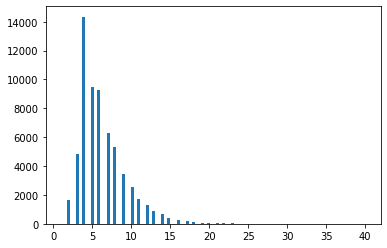

In [ ]:
x_lenn = []
for i in xTrainProfIndexes:
    x_lenn.append(len(i))
plt.hist(x_lenn, bins = 100)
plt.show()

In [ ]:
xTrainProf01 = pad_sequences(xTrainProfIndexes, 12)
xTrainProf01.shape

(62967, 12)

In [ ]:
# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []
  
  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]
    
    if (getParameterSalary(val[1]) != -1):
      xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return xTrainTRez

In [ ]:
xTrainTRez = getXTrainTRez(fixed_df.values)

In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', char_level=False, )
tokenizer.fit_on_texts(xTrainTRez)  

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez)

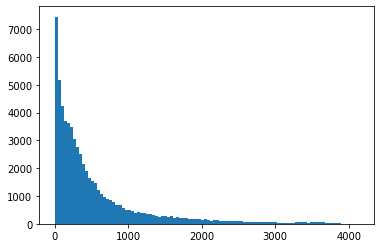

In [ ]:
x_lenn = []
for i in xTrainRezIndexes:
    x_lenn.append(len(i))
plt.hist(x_lenn, bins = 100)
plt.show()

In [ ]:
xTrainRez01 = pad_sequences(xTrainRezIndexes, 600)
xTrainRez01.shape

(62967, 600)

Epoch 1/150
391/391 [==============================] - 3s 7ms/step - loss: 1.7212 - mae: 0.5328 - val_loss: 0.1959 - val_mae: 0.2974
Epoch 2/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1385 - mae: 0.3247 - val_loss: 0.1784 - val_mae: 0.2676
Epoch 3/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1176 - mae: 0.3022 - val_loss: 0.1933 - val_mae: 0.3179
Epoch 4/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1181 - mae: 0.3009 - val_loss: 0.1777 - val_mae: 0.2781
Epoch 5/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1189 - mae: 0.3014 - val_loss: 0.1857 - val_mae: 0.2646
Epoch 6/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1164 - mae: 0.2993 - val_loss: 0.1729 - val_mae: 0.2681
Epoch 7/150
391/391 [==============================] - 2s 6ms/step - loss: 1.1166 - mae: 0.3014 - val_loss: 0.1911 - val_mae: 0.2968
Epoch 8/150
391/391 [==============================] - 2s 6ms/step - 

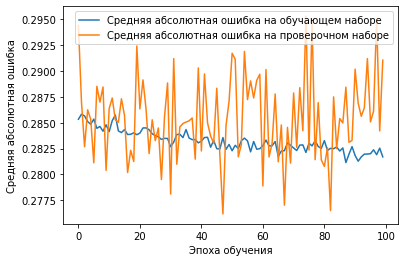

In [ ]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

# x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(250, activation="relu")(input2)
x2 = Dense(200, activation="tanh")(x2)
x2 = Dense(100, activation = "elu")(x2)

#x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(500, activation="tanh")(input3)
x3 = Dense(200, activation = "elu")(x3)
x3 = Dense(100, activation = "elu")(x3)

x = concatenate([x1, x2, x3]) # Объединяем все три ветки , x3

x = Dense(200, activation='linear')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='linear')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2, input3), x) # В Model загружаем стартовые и последнюю точки 


model.compile(optimizer=RMSprop(lr=1e-3), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000],  xTrainProf01[:50000],xTrainRez01[:50000]], 
                    yTrainScaled[:50000], 
                    epochs=150, 
                    validation_data=([xTrain01[50000:],  xTrainProf01[50000:],xTrainRez01[50000:]], 
                    yTrainScaled[50000:]), 
                    batch_size=128,
                    verbose=1)

model.compile(optimizer=RMSprop(lr=1e-4), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]], 
                    yTrainScaled[:50000], 
                    epochs=150, 
                    validation_data=([xTrain01[50000:],  xTrainProf01[50000:],xTrainRez01[50000:]], 
                    yTrainScaled[50000:]), 
                    batch_size=128,
                    verbose=1)

model.compile(optimizer=RMSprop(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]], 
                    yTrainScaled[:50000], 
                    epochs=100, 
                    validation_data=([xTrain01[50000:],  xTrainProf01[50000:],xTrainRez01[50000:]], 
                    yTrainScaled[50000:]), 
                    batch_size=128,
                    verbose=1)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

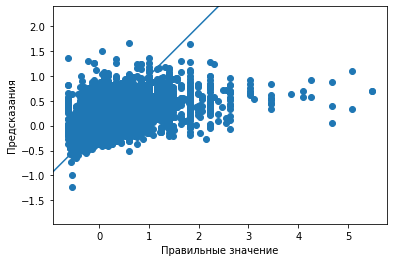

In [ ]:
yy = yTrainScaled[50000:] # Зарплата
pred = model.predict([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]]) # Предсказанная зарплата
plt.scatter(yy, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 5000], [-1000, 5000])
plt.show()